In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from matplotlib import cm

In this file, we are concerned with a 4-AUV formation, and obtaining a way to recover the shrimp position. 

To begin, we read in data of each AUV. Each of these contains information on when a signal occured.
The data has already been processed, so that it only includes snapping shrimp present in every AUV. 

The first set of reads are for location data, and the second set of reads are timestamps of signals.

The location data is a set of (x,y) coordinations at various time intervals.

In [103]:
init = pd.read_csv('locationData/time_wav5.csv', header=None).T
u7 = pd.read_csv('locationData/unit7.csv')
u8 = pd.read_csv('locationData/unit8.csv')
u13 = pd.read_csv('locationData/unit13.csv')
u20 = pd.read_csv('locationData/unit20.csv')

u7snaps = pd.read_csv('PeakTimeLocationData/Unit7PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u8snaps = pd.read_csv('PeakTimeLocationData/Unit8PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u13snaps = pd.read_csv('PeakTimeLocationData/Unit13PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
u20snaps = pd.read_csv('PeakTimeLocationData/Unit20PeakTimes.csv', header=None, names = ["dirtime", "reftime"])
startTime = init.iloc[1][0]
endTime = init.iloc[1][1]


In [104]:
#This "normalizes" the location data present to start at ~0. 
u7['GPS_time']=u7['GPS_time']-startTime
u8['GPS_time']=u8['GPS_time']-startTime
u13['GPS_time']=u13['GPS_time']-startTime
u20['GPS_time']=u20['GPS_time']-startTime


We interpolate the location data.

In [106]:
u7 = u7[u7['GPS_time'] <= 1100]  
u8 = u8[u8['GPS_time'] <= 1100]  
u13 = u13[u13['GPS_time'] <= 1100]  
u20 = u20[u20['GPS_time'] <= 1100] 

tnew = np.linspace(20, 1000, num=981)
u7pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u7['GPS_time'], u7['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u7['GPS_time'], u7['y'], kind='nearest')(tnew)})

u8pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u8['GPS_time'], u8['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u8['GPS_time'], u8['y'], kind='nearest')(tnew)})

u13pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u13['GPS_time'], u13['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u13['GPS_time'], u13['y'], kind='nearest')(tnew)})

u20pos = pd.DataFrame({'time':tnew, 'xpos':interp1d(u20['GPS_time'], u20['x'], kind='nearest')(tnew),
                      'ypos':interp1d(u20['GPS_time'], u20['y'], kind='nearest')(tnew)})

An example of our interpolated (x,y) locations for AUV 7.

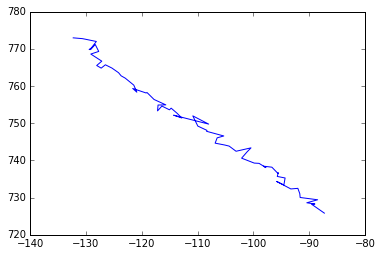

In [72]:
plt.plot(u7pos['xpos'], u7pos['ypos'])
plt.show();

For each AUV data, we round each snap, and get the position of the AUV at the time of each snap.  

In [124]:
u7snaps['dirtimer'] = u7snaps['dirtime'].round()
u7snaps = u7snaps.loc[:, ['dirtime', 'dirtimer']];
u7postime = u7pos.loc[u7pos['time'].isin(u7snaps[u7snaps['dirtimer'] < 1000]['dirtimer'])]
u7postime = u7postime.drop_duplicates()

u8snaps['dirtimer'] = u8snaps['dirtime'].round()
u8snaps = u8snaps.loc[:, ['dirtime', 'dirtimer']];
u8postime = u8pos.loc[u8pos['time'].isin(u8snaps[u8snaps['dirtimer'] < 1000]['dirtimer'])]
u8postime = u8postime.drop_duplicates()

u13snaps['dirtimer'] = u13snaps['dirtime'].round()
u13snaps = u13snaps.loc[:, ['dirtime', 'dirtimer']];
u13postime = u13pos.loc[u13pos['time'].isin(u13snaps[u13snaps['dirtimer'] < 1000]['dirtimer'])]
u13postime = u13postime.drop_duplicates()

u20snaps['dirtimer'] = u20snaps['dirtime'].round()
u20snaps = u20snaps.loc[:, ['dirtime', 'dirtimer']];
u20postime = u20pos.loc[u20pos['time'].isin(u20snaps[u20snaps['dirtimer'] < 1000]['dirtimer'])]
u20postime = u20postime.drop_duplicates()

The next set of code gets time of arrivals of every snap present across all AUVs.

In [134]:
direct = pd.DataFrame()

direct['u7dir'] = u7snaps[u7snaps['dirtimer'] < 1000]['dirtime']
direct['u8dir'] = u8snaps[u8snaps['dirtimer'] < 1000]['dirtime']
direct['u13dir'] = u13snaps[u13snaps['dirtimer'] < 1000]['dirtime']
direct['u20dir'] = u20snaps[u20snaps['dirtimer'] < 1000]['dirtime']

dirdiff = pd.DataFrame()
dirdiff['7-8'] = direct['u7dir']-direct['u8dir']
dirdiff['7-13'] = direct['u7dir']-direct['u13dir']
dirdiff['7-20'] = direct['u7dir']-direct['u20dir']
dirdiff['8-13'] = direct['u8dir']-direct['u13dir']
dirdiff['8-20'] = direct['u8dir']-direct['u20dir']
dirdiff['13-20'] = direct['u13dir']-direct['u20dir']

dirdiff.insert(0, "time", u7snaps['dirtimer'])


Now, we develop some functions to 

1. Get the 4 positions at each time. The input should be a time of a snap.
2. Get the time difference of each snap to every other AUV. The input should be a time of a snap.

In [135]:
def getPosAtTime(t):
    u7p = u7postime.loc[u7postime['time']==t][['xpos','ypos']]
    u8p = u8postime.loc[u8postime['time']==t][['xpos','ypos']]
    u13p = u13postime.loc[u13postime['time']==t][['xpos','ypos']]
    u20p = u20postime.loc[u20postime['time']==t][['xpos','ypos']]
    return [u7p, u8p, u13p, u20p]

#getTimeDiff at signal specified at second s
def getTimeDiffAtTime(t):
    return dirdiff.loc[dirdiff['time']==t].values[0][1:7]


Examples below. There is a snap at t=26 seconds

In [136]:
auvPos = getPosAtTime(26)

The next two functions are copied from a previous notebook. The first gets the position difference of every AUV from a "guessed" shrimp position.

The second one is a loss function, which we are trying to minimize (by repeatedly calling with different inputs ("guessed shrimp position")

In [131]:

def getDiffFromShrimp(shrimpPos):
    diff = [[0,0],[0,0],[0,0],[0,0]]
    for i in range(len(auvPos)):
        #print(shrimpPos[0])
        #print(auvPos[i][0])
        #print(shrimpPos[0])
        diff[i] = [float(shrimpPos[0] - auvPos[i]['xpos']), float(shrimpPos[1] - auvPos[i]['ypos'])];
    return diff


def loss(s):
    error = np.zeros(6)
    k = 0
    diff = getDiffFromShrimp(s)
    for i in range(4):
        for j in range(i+1,4):
            #print(i,j)
            #print(s)
            error[k] = timediff[k]*1498-(np.linalg.norm(diff[i])-np.linalg.norm(diff[j]))
            
            k = k+1
    return error


Next, we perform out algorithm on every snap present, with an initial guessed location of (-200, -80). Clearly, our results are not the greatest as we are
recovering locations over 1 million meters away. Regardless...



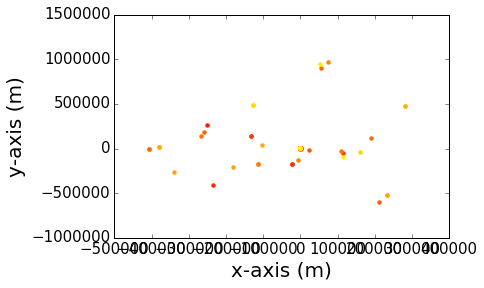

In [149]:
co=0
colors2 = cm.autumn(np.linspace(0,1,266))

for i in dirdiff['time']:
    auvPos = getPosAtTime(i)
    timediff = getTimeDiffAtTime(i)
    try:
        initial_estimates=[-200,-80]
        res = least_squares(loss, initial_estimates)
        plt.scatter(res.x[0],res.x[1],c=colors2[co], cmap=cm.hot, linewidth=0.0)
    except TypeError:
        continue
    co = (co + 1)

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=20) 
plt.xlabel('x-axis (m)')
plt.ylabel('y-axis (m)')
plt.show()

    

We present an example with an inidivual snap that occurs at time t=89s. The AUV locations are labelled in blue, and a recovered shrimp location is labelled with an x. With a guessed position of (50,50) the recovered locations is (-300, 500). Not bad!

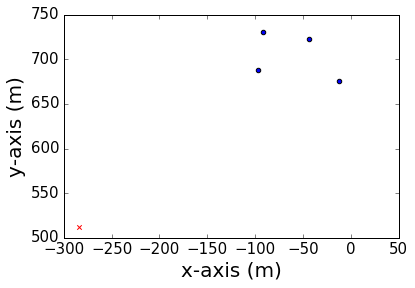

In [155]:
i = 89
auvPos = getPosAtTime(i)
#print(auvPos)
timediff = getTimeDiffAtTime(i)
init = [50,50]
res = least_squares(loss, init)
plt.scatter(res.x[0],res.x[1],marker='x',c='r')

plt.scatter(auvPos[0]['xpos'],auvPos[0]['ypos'],c='b')
plt.scatter(auvPos[1]['xpos'],auvPos[1]['ypos'],c='b')
plt.scatter(auvPos[2]['xpos'],auvPos[2]['ypos'],c='b')
plt.scatter(auvPos[3]['xpos'],auvPos[3]['ypos'],c='b')
        
plt.xlabel('x-axis (m)')
plt.ylabel('y-axis (m)')
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=20) 
plt.show();


Based on our previous conclusion, we do not beleive our data is accurate for shrimp locations that are far away relative to the distance between each of the 4 AUVs.